In [126]:
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import os
import math
import itertools
import glob
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shapely.geometry import Point, LineString, LinearRing
import re
from pyproj import Proj, transform
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
import numpy as np

def interp_intercept(x, y1, y2, reverse=False):
    """Find the intercept of two curves, given by the same x data"""
    
    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the first line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y

        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    try:
        
        if isinstance(y2, (int, float)):

            y2 = np.array([y2] * len(x))

        if reverse:

            x = x[::-1]
            y1 = y1[::-1]
            y2 = y2[::-1]

        idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
        xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), 
                           ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))

        return xc[0][0]
    
    except: 
        
        return np.nan
    
    
def dist_along_transect(dist, origin_x, origin_y, end_x, end_y):    
 
    if dist > 0:

        # Create distance line buffer around origin point
        poly = Point(origin_x, origin_y).buffer(dist) 
        poly_ring = LinearRing(list(poly.exterior.coords))
        
        # Find where transect intersects with line buffer
        path = LineString([Point(origin_x, origin_y), Point(end_x, end_y)])
        coord_x, coord_y = poly_ring.intersection(path).coords.xy

        # Returns coordinates of intersection
        return coord_x[0], coord_y[0]
    
    # If distance is 0, simply return origin x and y coords
    else:
        
        return origin_x, origin_y
    

In [21]:
import scipy
import numpy as np

input_array =  np.array([[5, 5, 7, 7],
                         [5, 5, 7, 7], 
                         [5, 5, 7, 7]])
label_array =  np.array([[0, 0, 1, 1],
                         [0, 0, 1, 1], 
                         [2, 2, 2, 2]])

# id_regions, num_ids = scipy.ndimage.label(label_array, structure=np.ones((3,3)))
id_sizes = np.array(scipy.ndimage.sum(label_array, id_regions, range(num_ids + 1)))
id_sizes 

# area_mask = (id_sizes == 1)


scipy.ndimage.sum(input_array > 0, label_array, label_array)

# scipy.ndimage.

# filtered_array[area_mask[id_regions]] = 0

array([[4., 4., 4., 4.],
       [4., 4., 4., 4.],
       [4., 4., 4., 4.]])

array([0, 1, 2])

In [6]:
id_regions

array([[0, 0, 1, 1],
       [0, 0, 1, 1],
       [1, 1, 1, 1]], dtype=int32)

## NSW Beach Profile Database
To do: resolve issues with 0 elevation 0 distance LiDAR values

To do: possibly use find_peaks(x, prominence=2) for foredune identification

In [628]:
sites = ['Palm Beach']

for site in sites:

    # Read in data
    profiles_df = pd.read_csv(f'validation/raw_data/NSW_BeachProfileDatabase/photogrammetry_Xsections_{site}.csv', skiprows=5, parse_dates=True)
    profiles_df = profiles_df[profiles_df['Year/Date'] > '1987']

    # Add ID column
    profiles_df['site'] = profiles_df['Beach'].map(str) + '_' + profiles_df['Block'].map(str) + '_' + profiles_df['Profile'].map(str)

    # Rename columns
    profiles_df.rename({'Year/Date': 'date', 'Survey Type': 'source', 'Beach': 'beach', 'Block': 'section', 'Profile': 'profile'}, axis=1, inplace=True)

    # Compute origin and end points for each profile
    origin_xy = profiles_df.loc[profiles_df.groupby(['site']).Chainage.idxmin(), ['site', 'Easting', 'Northing']]
    end_xy = profiles_df.loc[profiles_df.groupby(['site']).Chainage.idxmax(), ['site', 'Easting', 'Northing']]
    origin_xy.rename({'Easting': 'origin_x', 'Northing': 'origin_y'}, inplace=True, axis=1)
    end_xy.rename({'Easting': 'end_x', 'Northing': 'end_y'}, inplace=True, axis=1)
    end_xy.reset_index(drop=True, inplace=True)
    origin_xy.reset_index(drop=True, inplace=True)

    # Join origin and end points into dataframe
    profiles_df = pd.merge(left=profiles_df, right=origin_xy)
    profiles_df = pd.merge(left=profiles_df, right=end_xy)
    
    # Restrict all profiles to foredune: area seaward of highest elevation
    profiles_df = (profiles_df
                   .groupby(['site', 'date'], as_index=False)
                   .apply(lambda x: x[x['Chainage'] > x.loc[x.Elevation.idxmax(), 'Chainage']])
                   .reset_index(drop=True))
    
    # Identify distance and coordinates of foredune and add to dataframe
    foredune = profiles_df.loc[profiles_df.groupby(['site', 'date']).Chainage.idxmin(), ['site', 'date', 'Easting', 'Northing', 'Chainage']]
    foredune.rename({'Chainage': 'foredune_dist', 'Easting': 'foredune_x', 'Northing': 'foredune_y'}, inplace=True, axis=1)
    profiles_df = pd.merge(left=profiles_df, right=foredune)

    # Find location and distance to water for a set of datum heights (0, 0.5, 1.0m AHD)
    profiles_interp = []

    for datum in [0.0, 0.5, 1.0]:        

        out = (profiles_df.groupby(['site', 'date'])
               
               # Identify most sea-ward location where datum elevation intersects with elevation profile
               .apply(lambda x: pd.Series({f'ahd{datum}_dist': interp_intercept(x.Chainage.values,x.Elevation.values, datum, True),
                                           f'ahd{datum}_x': interp_intercept(x.Easting.values,x.Elevation.values, datum, True),
                                           f'ahd{datum}_y': interp_intercept(x.Northing.values,x.Elevation.values, datum, True)})))

        # Append result to list
        profiles_interp.append(out.astype(np.float64))

    # Join values back into dataframe
    shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
    shoreline_dist.drop(['Chainage', 'Elevation', 'Easting', 'Northing'], axis=1, inplace=True)
    shoreline_dist.reset_index(inplace=True)

    # Fix datetime
    shoreline_dist['date'] = pd.to_datetime(shoreline_dist.date)

    # Enforce column order
    shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 
                                     'origin_x', 'origin_y', 'end_x', 'end_y', 
                                     'foredune_dist', 'foredune_x', 'foredune_y',
                                     'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 
                                     'ahd0.5_dist', 'ahd0.5_x', 'ahd0.5_y', 
                                     'ahd1.0_dist', 'ahd1.0_x', 'ahd1.0_y']]

    # Write to file
    shoreline_dist.to_csv(f'validation/processed/validation_{site}.csv', index=False)

shoreline_dist.head()

,site,beach,section,profile,date,source,origin_x,origin_y,end_x,end_y,...,foredune_y,ahd0.0_dist,ahd0.0_x,ahd0.0_y,ahd0.5_dist,ahd0.5_x,ahd0.5_y,ahd1.0_dist,ahd1.0_x,ahd1.0_y
0,Palm Beach_1_1,Palm Beach,1,1,1988-03-10,Stereo photogrammtery,344694.2,6280887.04,344772.32,6280963.4,...,6280892.41,NaN,NaN,NaN,101.059667,344766.455462,6.280958e+06,88.226333,344757.278755,6.280949e+06
1,Palm Beach_1_1,Palm Beach,1,1,1996-05-30,Stereo photogrammtery,344694.2,6280887.04,344772.32,6280963.4,...,6280894.20,69.759523,344744.084452,6.280936e+06,63.805088,344739.826387,6.280932e+06,58.356268,344735.929990,6.280928e+06
2,Palm Beach_1_1,Palm Beach,1,1,2001-09-13,Stereo photogrammtery,344694.2,6280887.04,344772.32,6280963.4,...,6280894.22,81.126812,344752.205296,6.280944e+06,76.140132,344748.641293,6.280940e+06,71.153452,344745.077290,6.280937e+06
3,Palm Beach_1_1,Palm Beach,1,1,2008-07-03,Stereo photogrammtery,344694.2,6280887.04,344772.32,6280963.4,...,6280895.44,95.477783,344762.465073,6.280954e+06,90.256848,344758.733366,6.280950e+06,85.035913,344755.001659,6.280946e+06
4,Palm Beach_1_1,Palm Beach,1,1,2011-12-31,Stereo photogrammtery,344694.2,6280887.04,344772.32,6280963.4,...,6280896.59,103.399229,344768.208193,6.280959e+06,99.142361,344765.162410,6.280956e+06,94.885494,344762.116627,6.280953e+06


In [103]:
# profiles_df.groupby(/['site', 'date']).apply(lambda x: pd.Series({'foredune': x.loc[x.Elevation.idxmax(), 'Chainage']})).loc['Avoca_5_6']

# profiles_df.groupby(['site', 'date']).filter(lambda x: x['Chainage'].mean() > x.loc[x.Elevation.idxmax(), 'Chainage'])
# x = profiles_df[(profiles_df.section == 5) & (profiles_df.profile == 6) &  (profiles_df.date == '2016-06-07')]  



# groups.apply(lambda g: g[g['B'] == g['B'].max()])
# out = x.loc[x.Elevation.idxmax(), 'Chainage']


# df.groupby('c')['type'].transform('size')

    
# Restrict all profiles to foredune: area seaward of highest elevation
# profiles_df.groupby(['site', 'date']).transform(func = lambda x: x.loc[x.Elevation.idxmax(), 'Chainage'], axis=1)



In [269]:
# profiles_df.date.unique()

# shoreline_dist[shoreline_dist.site == 'Tweed Entrance_5_5']

,site,beach,section,profile,date,source,origin_x,origin_y,end_x,end_y,...,foredune_y,ahd0.0_dist,ahd0.0_x,ahd0.0_y,ahd0.5_dist,ahd0.5_x,ahd0.5_y,ahd1.0_dist,ahd1.0_x,ahd1.0_y
102,Tweed Entrance_5_5,Tweed Entrance,5,5,1999-09-05,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883681.83,345.061063,554568.881472,6.883754e+06,333.241026,554557.412647,6.883751e+06,326.421245,554550.795000,6.883749e+06
103,Tweed Entrance_5_5,Tweed Entrance,5,5,2004-07-14,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883693.25,NaN,NaN,NaN,260.048785,554486.569522,6.883733e+06,248.435019,554475.298191,6.883731e+06
104,Tweed Entrance_5_5,Tweed Entrance,5,5,2007-03-12,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883695.48,NaN,NaN,NaN,239.614889,554466.607015,6.883728e+06,235.818593,554462.923391,6.883728e+06
105,Tweed Entrance_5_5,Tweed Entrance,5,5,2010-01-26,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883679.17,258.964700,554485.380040,6.883733e+06,253.851999,554480.420201,6.883732e+06,248.739298,554475.460361,6.883731e+06
106,Tweed Entrance_5_5,Tweed Entrance,5,5,2014-09-16,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883674.10,394.576000,554617.040000,6.883766e+06,277.873000,554503.765000,6.883738e+06,249.997111,554476.708889,6.883731e+06
107,Tweed Entrance_5_5,Tweed Entrance,5,5,2016-08-01,LiDar,554234.08,6883670.84,554634.11,6883770.27,...,6883709.22,270.848484,554496.946774,6.883736e+06,254.589657,554481.164000,6.883732e+06,243.046000,554469.964000,6.883730e+06


In [340]:
# test = profiles_df[(profiles_df.site == 'Tweed Entrance_5_5') & (profiles_df.date == '2014-09-16')]  
# test.plot(x='Chainage', y='Elevation')
# test 

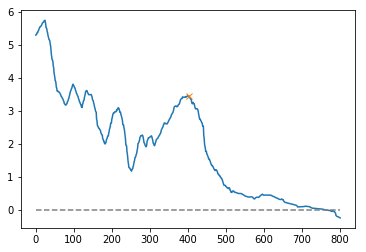

In [339]:
test = profiles_df[(profiles_df.site == 'Tweed Entrance_5_5') & (profiles_df.date == '2014-09-16')]  

import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
x = test.Elevation.values # electrocardiogram()[2000:4000]
peaks, _ = find_peaks(x, prominence=2)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
x = test.Elevation.values # electrocardiogram()[2000:4000]
peaks, _ = find_peaks(x,prominence=2)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [272]:
x

array([-0.9  , -0.895, -0.895, ..., -0.67 , -0.65 , -0.615])

In [199]:
test = profiles_df[(profiles_df.site == 'Avoca_5_1') & (profiles_df.date == '2008-07-03')] 
interp1d(test.sort_values('Chainage').Elevation, test.sort_values('Chainage').Chainage, assume_sorted=False)(0)

array(133.81565065)

In [211]:
xp = [1, 2, 3]
fp = [3, 2, 0]
np.interp(2.5, test.Elevation, test.Chainage)

201.03900000000002

In [262]:
from __future__ import division 
import numpy as np
import matplotlib.pyplot as plt



x  = test.Chainage.values
y1 = test.Elevation.values
y2 = 0.5 

# new method!
interp_intercept(x, y1, y2, reverse=False)

37.664562264150945

array([1, 1, 1, 1, 1, 1, 1])

In [227]:
np.array([5., 5., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0.])

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: 'site' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  app.launch_new_instance()


,,,site,Easting,Northing,Chainage
site,date,,,,,
Avoca_7_5,1990-05-04,32805,Avoca_7_5,354811.94,6296594.73,61.08


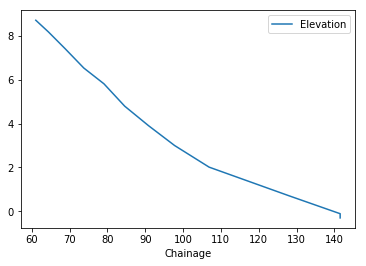

In [69]:
test = profiles_df[(profiles_df.section == 7) & (profiles_df.profile == 5) &  (profiles_df.date == '1990-05-04')]
test.plot(x='Chainage', y='Elevation')
test.loc[test.groupby(['site']).Elevation.idxmax(), ['site', 'Easting', 'Northing', 'Chainage']]

## Gold Coast

In [472]:
# List of sites to iterate over
sites = ['BILINGA',
         'BROADBEACH',
         'BURLEIGH HEADS',
         'COOLANGATTA',
         'CURRUMBIN',
         'DURANBAH',
         'FINGAL',
         'GREENMOUNT HILL',
         'KINGSCLIFF',
         'KIRRA RADIALS',
         'MAIN BEACH',
         'MERMAID BEACH',
         'MIAMI',
         'Main Beach Cross Sections',
         'NARROWNECK',
         'NORTH KIRRA',
         'PALM BEACH',
         'POINT DANGER',
         'RAINBOW BAY',
         'SEAWAY CENTRE LINE',
         'SNAPPER ROCKS',
         'SOUTH STRADBROKE',
         'SURFERS PARADISE',
         'THE SPIT',
         'TUGUN',
         'TWEED RIVER ENTRANCE']

sites = ['COOLANGATTA']

# Dictionary to manually rename problematic surveys
manual_rename = {'BILINGA K37A': 'BILINGA', 'CURRUMBIN (27A)': 'CURRUMBIN', 'NORTH KIRRA (confirmed)':'NORTH KIRRA', 
                 'PALM BEACH (28A)':'PALM BEACH', 'PALM BEACH (30A)':'PALM BEACH', 'PALM BEACH (31A)':'PALM BEACH', 
                 'SURFERS PARADISE (no longer used)': 'SURFERS PARADISE'}

failed_list = []

for site in sites:
    
    print(site)
    
    ##################################
    # Extract profiles for each site #
    ##################################   
    
    # List of profile datasets to iterate through
    profile_list = glob.glob(f'validation/raw_data/CityofGoldCoast/ETA Lines- 20181213/{site}*.txt')
    
    # Output list to hold data
    site_profiles = []

    for profile_i in profile_list:

        try:

            # Identify unique field values from file string
            profile_string = os.path.basename(profile_i)

            # Treat data file string differently depending on format
            if len(profile_string.split(' - ')) > 3:

                beach, section, profile, id_date = profile_string.split(' - ')            

            else:

                beach, section_profile, id_date = profile_string.split(' - ')
                section, profile = section_profile.split(' ')
            
            # If beach name is in the list of problematic names, replace
            if beach in manual_rename.keys():      
                beach = manual_rename[beach]
            
            # Remove any special characters from beach/section/profile names and create ID 
            beach = beach.replace(' ', '') 
            name = (beach + '_' + section + '_' + profile).replace('\xa0', '').replace(' ', '')    
            date = id_date[-14:-4]

            # Import data and add in fields
            profile_df = pd.read_csv(profile_i, delim_whitespace=True, names=['point_id', 'x', 'y', 'z'])
            profile_df['date'] = date
            profile_df['site'] = name        
            profile_df['profile'] = profile  
            profile_df['section'] = section 
            profile_df['beach'] = beach 

            # If profile has data above any datum height (0, 0.5, 1.0 m), add to list for processing
            if profile_df.z.max() > 0:
                site_profiles.append(profile_df)

        except:

            failed_list.append(profile_i)            

    try:
        
        # Combine into a single dataframe, and drop pre-1987 and deep water samples
        profiles_df = pd.concat(site_profiles)
        profiles_df = profiles_df[profiles_df.z > -3.0]
        profiles_df = profiles_df[profiles_df.date > '1987']
        profiles_df.drop('point_id', axis=1, inplace=True)

        # Compute origin and end points for each profile
        origin_xy = profiles_df.groupby(['site']).first().reset_index()[['site', 'x', 'y']]
        end_xy = profiles_df.groupby(['site']).last().reset_index()[['site', 'x', 'y']]
        origin_xy.rename({'x': 'origin_x', 'y': 'origin_y'}, inplace=True, axis=1)
        end_xy.rename({'x': 'end_x', 'y': 'end_y'}, inplace=True, axis=1)
        end_xy.reset_index(drop=True, inplace=True)
        origin_xy.reset_index(drop=True, inplace=True)

        # Join origin and end points into dataframe
        profiles_df = pd.merge(left=profiles_df, right=origin_xy)
        profiles_df = pd.merge(left=profiles_df, right=end_xy)

        # Compute chainage
        profiles_df['Chainage'] = profiles_df.apply(lambda x: math.hypot(x.x - x.origin_x, x.y - x.origin_y), axis = 1)
        
        # Restrict all profiles to foredune: area seaward of highest elevation
        profiles_df = (profiles_df
                       .groupby(['site', 'date'], as_index=False)
                       .apply(lambda x: x[x['Chainage'] > x.loc[x.z.idxmax(), 'Chainage']])
                       .reset_index(drop=True))
    
        # Identify distance and coordinates of foredune and add to dataframe
        foredune = profiles_df.loc[profiles_df.groupby(['site', 'date']).Chainage.idxmin(), ['site', 'date', 'x', 'y', 'Chainage']]
        foredune.rename({'Chainage': 'foredune_dist', 'x': 'foredune_x', 'y': 'foredune_y'}, inplace=True, axis=1)
        profiles_df = pd.merge(left=profiles_df, right=foredune)

        # Find location and distance to water / X AHD
        profiles_interp = []        
            
        for datum in [0.0, 0.5, 1.0]:

            out = (profiles_df.groupby(['site', 'date'])

                   # Identify most sea-ward location where datum elevation intersects with elevation profile
                   .apply(lambda x: pd.Series({f'ahd{datum}_dist': interp_intercept(x.Chainage.values, x.z.values, datum, True),
                                               f'ahd{datum}_x': interp_intercept(x.x.values, x.z.values, datum, True),
                                               f'ahd{datum}_y': interp_intercept(x.y.values, x.z.values, datum, True)})))

            profiles_interp.append(out.astype(np.float64))

        # Join values back into dataframe
        shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
        shoreline_dist.drop(['Chainage', 'z', 'x', 'y'], axis=1, inplace=True)
        shoreline_dist.reset_index(inplace=True)

        # Fix datetime
        shoreline_dist['date'] = pd.to_datetime(shoreline_dist.date)

        # Insert annotation column
        shoreline_dist.insert(2, 'source', 'CityofGoldCoast')

        # Enforce column order
        shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 
                                         'origin_x', 'origin_y', 'end_x', 'end_y', 
                                         'foredune_dist', 'foredune_x', 'foredune_y',
                                         'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 
                                         'ahd0.5_dist', 'ahd0.5_x', 'ahd0.5_y', 
                                         'ahd1.0_dist', 'ahd1.0_x', 'ahd1.0_y']]

        # Write to file
        shoreline_dist.to_csv(f'validation/processed/validation_{beach}.csv', index=False)
        shoreline_dist.head()
        
    except: 
        print(f'Skipping {site}')
        

COOLANGATTA


In [438]:
# # profile_i = 'validation/raw_data/CityofGoldCoast/ETA Lines- 20181213/NARROWNECK - ETA 67.0075 - (15685) 1999-10-06.txt'
# # profiles_df = pd.read_csv(profile_i, delim_whitespace=True, names=['point_id', 'x', 'y', 'z'])
# # profiles_df.head()
# # profiles_df['site'] = 'test'

# # List of profile datasets to iterate through
# profile_list = glob.glob(f'validation/raw_data/CityofGoldCoast/ETA Lines- 20181213/NARROWNECK - ETA 67.0075*.txt')

# # Output list to hold data
# site_profiles = []

# for profile_i in profile_list:

#     try:

#         # Identify unique field values from file string
#         profile_string = os.path.basename(profile_i)

#         # Treat data file string differently depending on format
#         if len(profile_string.split(' - ')) > 3:

#             beach, section, profile, id_date = profile_string.split(' - ')            

#         else:

#             beach, section_profile, id_date = profile_string.split(' - ')
#             section, profile = section_profile.split(' ')

#         # If beach name is in the list of problematic names, replace
#         if beach in manual_rename.keys():      
#             beach = manual_rename[beach]

#         # Remove any special characters from beach/section/profile names and create ID 
#         beach = beach.replace(' ', '') 
#         name = (beach + '_' + section + '_' + profile).replace('\xa0', '').replace(' ', '')    
#         date = id_date[-14:-4]

#         # Import data and add in fields
#         profile_df = pd.read_csv(profile_i, delim_whitespace=True, names=['point_id', 'x', 'y', 'z'])
#         profile_df['date'] = date
#         profile_df['site'] = name        
#         profile_df['profile'] = profile  
#         profile_df['section'] = section 
#         profile_df['beach'] = beach 

#         if profile_df.z.max() > 0:
#             site_profiles.append(profile_df)

#     except:

#         failed_list.append(profile_i)            

# site_profiles

# # Combine into a single dataframe, and drop pre-1987 and deep water samples
# profiles_df = pd.concat(site_profiles)
# profiles_df = profiles_df[profiles_df.z > -3.0]
# profiles_df = profiles_df[profiles_df.date > '1987']
# profiles_df.drop('point_id', axis=1, inplace=True)

# # Compute origin and end points for each profile
# origin_xy = profiles_df.groupby(['site']).first().reset_index()[['site', 'x', 'y']]
# end_xy = profiles_df.groupby(['site']).last().reset_index()[['site', 'x', 'y']]

In [478]:
profiles_df[(profiles_df.site == 'COOLANGATTA_BETA_1.2')].date.unique()

array(['1989-08-01', '1990-08-01', '1994-06-01', '1995-05-30',
       '1995-10-19', '1996-01-23', '1996-05-11', '1996-06-20',
       '1996-10-03', '1997-02-06', '1997-06-26', '1997-09-09',
       '1998-02-10', '1998-04-27', '1998-09-30', '1998-11-09',
       '2000-03-13', '2000-12-07', '2001-03-21', '2002-11-21',
       '2003-06-16', '2006-07-18', '2007-07-19', '2008-07-03',
       '2009-08-05', '2010-10-26', '2011-08-01', '2012-11-22',
       '2013-08-23', '2014-12-04', '2015-11-12', '2016-05-24',
       '2017-07-27'], dtype=object)

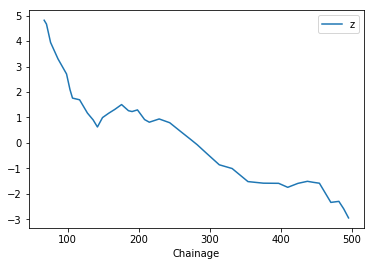

In [480]:
test = profiles_df[(profiles_df.site == 'COOLANGATTA_BETA_1.2')& (profiles_df.date == '2014-12-04') ]  
# test2 = profiles_df[(profiles_df.site == 'NARROWNECK_ETA_68.50')& (profiles_df.date == '2017-08-10') ]  
# test3 = profiles_df[(profiles_df.site == 'NARROWNECK_ETA_68.50')& (profiles_df.date == '2017-05-31') ]  
fix, ax = plt.subplots(1,1)
test.plot(x='Chainage', y='z', ax=ax)
# test2.plot(x='Chainage', y='z', ax=ax)
# test3.plot(x='Chainage', y='z', ax=ax)
# # test 

In [467]:
interp_intercept(test.Chainage.values, test.z.values, 0, True)

82.33997319373142

In [462]:
profiles_df[(profiles_df.site == 'NARROWNECK_ETA_68.50')].tail(100)

,x,y,z,date,site,profile,section,beach,origin_x,origin_y,end_x,end_y,Chainage,foredune_x,foredune_y,foredune_dist
28599,542515.2922,6.904656e+06,-2.94,2017-05-31,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,240.848417,542291.9907,6.904644e+06,17.266853
28600,542287.0428,6.904644e+06,2.31,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,12.326409,542287.0428,6.904644e+06,12.326409
28601,542296.0535,6.904644e+06,1.69,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,21.328526,542287.0428,6.904644e+06,12.326409
28602,542304.7517,6.904645e+06,1.39,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,30.030524,542287.0428,6.904644e+06,12.326409
28603,542309.7958,6.904645e+06,1.12,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,35.078740,542287.0428,6.904644e+06,12.326409
28604,542313.7014,6.904645e+06,0.93,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,38.988057,542287.0428,6.904644e+06,12.326409
28605,542322.7982,6.904646e+06,0.58,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,48.094615,542287.0428,6.904644e+06,12.326409
28606,542336.9404,6.904647e+06,0.12,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,62.253735,542287.0428,6.904644e+06,12.326409
28607,542351.9136,6.904647e+06,-0.03,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,77.246022,542287.0428,6.904644e+06,12.326409
28608,542363.4016,6.904648e+06,-0.25,2017-08-10,NARROWNECK_ETA_68.50,68.50,ETA,NARROWNECK,542274.8426,6.904642e+06,542531.4833,6.904656e+06,88.749099,542287.0428,6.904644e+06,12.326409


## Narrabeen

In [533]:

def dms2dd(s):
    # example: s = "0°51'56.29"
    degrees, minutes, seconds = re.split('[°\'"]+', s)
    if float(degrees) > 0:
        dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    else:
        dd = float(degrees) - float(minutes)/60 - float(seconds)/(60*60);
    return dd

def dist_angle(lon, lat, dist, angle):
    lon_2 = lon + dist *  np.sin(angle * np.pi / 180)
    lat_2 = lat + dist *  np.cos(angle * np.pi / 180)
    return pd.Series({'y2': lat_2, 'x2': lon_2})


# Import data and parse DMS to DD
data = "PF1 -33°42'20.65 151°18'16.30 118.42\nPF2 -33°42'33.45 151°18'10.33 113.36\nPF4 -33°43'01.55 151°17'58.84 100.26\nPF6 -33°43'29.81 151°17'58.65 83.65\nPF8 -33°43'55.94 151°18'06.47 60.48"
coords = pd.read_csv(pd.compat.StringIO(data), sep=' ', names=['profile', 'y', 'x', 'angle'])
coords['x'] = [dms2dd(i) for i in coords.x]
coords['y'] = [dms2dd(i) for i in coords.y]

# Extend survey lines out from start coordinates using supplied angle
coords_end = coords.apply(lambda x: dist_angle(x.x, x.y, 0.005, x.angle), axis = 1)
coords = pd.concat([coords, coords_end], axis=1).drop('angle', axis=1)

# Rename fields
coords = coords.rename({'y': 'origin_y', 'x': 'origin_x', 'y2': 'end_y', 'x2': 'end_x'}, axis=1)

# Reproject coords to Albers and create geodataframe
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:28356')
coords['origin_x'], coords['origin_y'] = transform(inProj,outProj,coords.origin_x.values,coords.origin_y.values)
coords['end_x'], coords['end_y'] = transform(inProj,outProj,coords.end_x.values,coords.end_y.values)

# Add ID column
coords['site'] = 'Narrabeen_all_' + coords['profile'].map(str)
coords['beach'] = 'Narrabeen'
coords['section'] = 'all'
coords['source'] = 'Beach profile'
coords.head()


,profile,origin_y,origin_x,end_y,end_x,site,beach,section,source
0,PF1,6.269180e+06,342880.107890,6.268923e+06,343291.986672,Narrabeen_all_PF1,Narrabeen,all,Beach profile
1,PF2,6.268784e+06,342732.895388,6.268571e+06,343161.902515,Narrabeen_all_PF2,Narrabeen,all,Beach profile
2,PF4,6.267913e+06,342451.362695,6.267822e+06,342908.919210,Narrabeen_all_PF4,Narrabeen,all,Beach profile
3,PF6,6.267043e+06,342460.817833,6.267111e+06,342920.268319,Narrabeen_all_PF6,Narrabeen,all,Beach profile
4,PF8,6.266241e+06,342675.346674,6.266521e+06,343073.983065,Narrabeen_all_PF8,Narrabeen,all,Beach profile


In [626]:
##############
# Validation #
##############

# Import data
profiles_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/raw_data/WRL/Narrabeen/Narrabeen_Profiles_2018.csv', 
                          usecols=[1,2,3,4,5], skiprows=1, names=['profile', 'date', 'distance', 'elevation', 'flag'])

# Set to datetime
profiles_df['date'] = pd.to_datetime(profiles_df['date'], format='%Y-%m-%d')

# Restrict to post 1987
profiles_df = profiles_df[(profiles_df.date.dt.year > 1987)]

# Add transect site and origin/end points into dataframe
profiles_df = profiles_df.merge(coords, on='profile')

# Add coordinates for every distance along transects
profiles_df[['x', 'y']] = profiles_df.apply(lambda x: pd.Series(dist_along_transect(x.distance, 
                                                                                    x.origin_x, x.origin_y, 
                                                                                    x.end_x, x.end_y)), axis = 1)

# Restrict all profiles to foredune: area seaward of highest elevation
profiles_df = (profiles_df
               .groupby(['site', 'date'], as_index=False)
               .apply(lambda x: x[x['distance'] > x.loc[x.elevation.idxmax(), 'distance']])
               .reset_index(drop=True))

# Identify distance and coordinates of foredune and add to dataframe
foredune = profiles_df.loc[profiles_df.groupby(['site', 'date']).distance.idxmin(), ['site', 'date', 'x', 'y', 'distance']]
foredune.rename({'distance': 'foredune_dist', 'x': 'foredune_x', 'y': 'foredune_y'}, inplace=True, axis=1)
profiles_df = pd.merge(left=profiles_df, right=foredune)

# Find location and distance to water / X AHD
profiles_interp = []

for datum in [0.0, 0.5, 1.0]:

    out = (profiles_df.groupby(['site', 'date'])
           
            # Identify most sea-ward location where datum elevation intersects with elevation profile
           .apply(lambda x: pd.Series({f'ahd{datum}_dist': interp_intercept(x.distance.values, x.elevation.values, datum, True),
                                       f'ahd{datum}_x': interp_intercept(x.x.values, x.elevation.values, datum, True),
                                       f'ahd{datum}_y': interp_intercept(x.y.values, x.elevation.values, datum, True)})))

    profiles_interp.append(out.astype(np.float64))

# Join values back into dataframe
shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
shoreline_dist.drop(['distance', 'elevation'], axis=1, inplace=True)
shoreline_dist.reset_index(inplace=True)

# Enforce column order
shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 
                                 'origin_x', 'origin_y', 'end_x', 'end_y', 
                                 'foredune_dist', 'foredune_x', 'foredune_y',
                                 'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 
                                 'ahd0.5_dist', 'ahd0.5_x', 'ahd0.5_y', 
                                 'ahd1.0_dist', 'ahd1.0_x', 'ahd1.0_y']]

# Write to file
shoreline_dist.to_csv(f'validation/processed/validation_Narrabeen.csv', index=False)
shoreline_dist.head()


,site,beach,section,profile,date,source,origin_x,origin_y,end_x,end_y,...,foredune_y,ahd0.0_dist,ahd0.0_x,ahd0.0_y,ahd0.5_dist,ahd0.5_x,ahd0.5_y,ahd1.0_dist,ahd1.0_x,ahd1.0_y
0,Narrabeen_all_PF1,Narrabeen,all,PF1,1988-01-25,Beach profile,342880.10789,6.269180e+06,343291.986672,6.268923e+06,...,6.269175e+06,103.642857,342967.927305,6.269126e+06,100.071429,342964.901137,6.269127e+06,96.048387,342961.492304,6.269130e+06
1,Narrabeen_all_PF1,Narrabeen,all,PF1,1988-02-23,Beach profile,342880.10789,6.269180e+06,343291.986672,6.268923e+06,...,6.269175e+06,95.500000,342961.027641,6.269130e+06,90.500000,342956.791005,6.269132e+06,86.938776,342953.773482,6.269134e+06
2,Narrabeen_all_PF1,Narrabeen,all,PF1,1988-03-21,Beach profile,342880.10789,6.269180e+06,343291.986672,6.268923e+06,...,6.269175e+06,96.350365,342961.748178,6.269129e+06,92.700730,342958.655743,6.269131e+06,89.103448,342955.607668,6.269133e+06
3,Narrabeen_all_PF1,Narrabeen,all,PF1,1988-04-20,Beach profile,342880.10789,6.269180e+06,343291.986672,6.268923e+06,...,6.269175e+06,102.383721,342966.860405,6.269126e+06,99.419355,342964.348617,6.269128e+06,96.193548,342961.615303,6.269129e+06
4,Narrabeen_all_PF1,Narrabeen,all,PF1,1988-06-11,Beach profile,342880.10789,6.269180e+06,343291.986672,6.268923e+06,...,6.269175e+06,97.734375,342962.920887,6.269129e+06,93.828125,342959.611015,6.269131e+06,89.936306,342956.313371,6.269133e+06


,profile,date,distance,elevation,flag,origin_y,origin_x,end_y,end_x,site,beach,section,source,foredune_dist
64,PF1,1988-04-20,10,8.79,DUNEFILL,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
65,PF1,1988-04-20,20,8.58,DUNEFILL,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
66,PF1,1988-04-20,30,7.47,DUNEFILL,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
67,PF1,1988-04-20,40,5.94,DUNEFILL,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
68,PF1,1988-04-20,50,4.29,DUNEFILL,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
69,PF1,1988-04-20,60,3.54,EMERY,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
70,PF1,1988-04-20,70,2.93,EMERY,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
71,PF1,1988-04-20,80,2.61,EMERY,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
72,PF1,1988-04-20,90,1.96,EMERY,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10
73,PF1,1988-04-20,100,0.41,EMERY,6.269180e+06,342880.107891,6.268923e+06,343291.986673,Narrabeen_all_PF1,Narrabeen,all,Beach profile,10


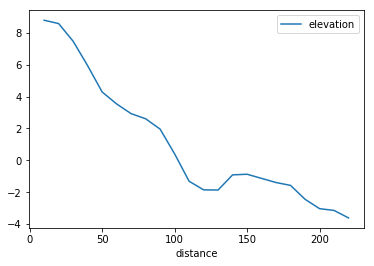

In [371]:
test = profiles_df[(profiles_df.site == 'Narrabeen_all_PF1') & (profiles_df.date == '1988-04-20')]  
test.plot(x='distance', y='elevation')
test 

## Moruya Beach

In [2]:
def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    return np.degrees(angle)if angle>0 else np.degrees(angle) + 360

def dist_angle(lon, lat, dist, angle):
    lon_2 = lon + dist *  np.sin(angle * np.pi / 180)
    lat_2 = lat + dist *  np.cos(angle * np.pi / 180)
    return pd.Series({'y2': lat_2, 'x2': lon_2})


# Import data
profiles_wide = pd.read_csv('validation/raw_data/Moruya/moroya_processed.csv')

# Set to datetime
profiles_wide['date'] = pd.to_datetime(profiles_wide['date'], format='%d/%m/%Y')

# Reshape to long format with one row per measurement
profiles_df = profiles_wide.melt(id_vars=profiles_wide.columns[0:8], 
                                 value_vars=profiles_wide.columns[8:], 
                                 var_name='distance', value_name='elevation')

# Drop rows with no elevation measurements
profiles_df = profiles_df.dropna(axis=0, subset=['elevation'])

# Convert units to metres
profiles_df['elevation'] = profiles_df['elevation'] * 0.01

# Convert distance strings to numeric distances
profiles_df['distance'] = profiles_df.apply(lambda x: int(x.distance[5:]), axis=1)

# Generate survey lines start and end points
profiles_df['angle'] = profiles_df.apply(lambda x: azimuth(Point(x.origin_x, x.origin_y), Point(x.mid_x, x.mid_y)), axis = 1)
profiles_df[['end_y', 'end_x']] = profiles_df.apply(lambda x: dist_angle(x.origin_x, x.origin_y, 300, x.angle), axis = 1)
profiles_df = profiles_df.drop(['mid_y', 'mid_x'], axis=1)

# Create site and source column
profiles_df['site'] = profiles_df['beach'].map(str) + '_' + profiles_df['section'].map(str) + '_' + profiles_df['profile'].map(str)
profiles_df['source'] = 'Andrew Short' 
profiles_df.head()

,beach,section,profile,date,origin_y,origin_x,distance,elevation,angle,end_y,end_x,site,source
0,moruya,all,1,2007-11-10,6021938.4,243479.21,0,4.7,113.777618,6.021817e+06,243753.745172,moruya_all_1,Andrew Short
1,moruya,all,1,2007-12-12,6021938.4,243479.21,0,4.7,113.777618,6.021817e+06,243753.745172,moruya_all_1,Andrew Short
2,moruya,all,1,2008-02-01,6021938.4,243479.21,0,4.7,113.777618,6.021817e+06,243753.745172,moruya_all_1,Andrew Short
3,moruya,all,1,2008-03-07,6021938.4,243479.21,0,4.7,113.777618,6.021817e+06,243753.745172,moruya_all_1,Andrew Short
4,moruya,all,1,2008-04-07,6021938.4,243479.21,0,4.7,113.777618,6.021817e+06,243753.745172,moruya_all_1,Andrew Short


In [3]:
# Add coordinates for every distance along transects
profiles_df[['x', 'y']] = profiles_df.apply(lambda x: pd.Series(dist_along_transect(x.distance, 
                                                                                    x.origin_x, x.origin_y, 
                                                                                    x.end_x, x.end_y)), axis = 1)

# Restrict all profiles to foredune: area seaward of highest elevation
profiles_df = (profiles_df
               .groupby(['site', 'date'], as_index=False)
               .apply(lambda x: x[x['distance'] > x.loc[x.elevation.idxmax(), 'distance']])
               .reset_index(drop=True))

# Identify distance and coordinates of foredune and add to dataframe
foredune = profiles_df.loc[profiles_df.groupby(['site', 'date']).distance.idxmin(), ['site', 'date', 'x', 'y', 'distance']]
foredune.rename({'distance': 'foredune_dist', 'x': 'foredune_x', 'y': 'foredune_y'}, inplace=True, axis=1)
profiles_df = pd.merge(left=profiles_df, right=foredune)

# Find location and distance to water / X AHD
profiles_interp = []

for datum in [0.0, 0.5, 1.0]:

    out = (profiles_df.groupby(['site', 'date'])
           
            # Identify most sea-ward location where datum elevation intersects with elevation profile
           .apply(lambda x: pd.Series({f'ahd{datum}_dist': interp_intercept(x.distance.values, x.elevation.values, datum, True),
                                       f'ahd{datum}_x': interp_intercept(x.x.values, x.elevation.values, datum, True),
                                       f'ahd{datum}_y': interp_intercept(x.y.values, x.elevation.values, datum, True)})))

    profiles_interp.append(out.astype(np.float64))

# Join values back into dataframe
shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
shoreline_dist.drop(['distance', 'elevation'], axis=1, inplace=True)
shoreline_dist.reset_index(inplace=True)

# Enforce column order
shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 
                                 'origin_x', 'origin_y', 'end_x', 'end_y', 
                                 'foredune_dist', 'foredune_x', 'foredune_y',
                                 'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 
                                 'ahd0.5_dist', 'ahd0.5_x', 'ahd0.5_y', 
                                 'ahd1.0_dist', 'ahd1.0_x', 'ahd1.0_y']]

# Write to file
shoreline_dist[shoreline_dist.beach=='moruya'].to_csv(f'validation/processed/validation_Moruya.csv', index=False)
shoreline_dist[shoreline_dist.beach=='pedro'].to_csv(f'validation/processed/validation_Pedro.csv', index=False)


## TASMARC

In [352]:
from itertools import takewhile

# List of profile datasets to iterate through
sites = ['spring_beach',
         'sisters_beach',
         'coles_beach',
         'shelly_beach',
         'wreck_bay',
         'adams_beach',
         'stephens_bay',
         'connellys_bay',
         'greens_beach',
         'alonnah',
         'detention_river',
         'raspins_beach',
         'randalls_bay',
         'simpsons_bay',
         'roches_beach',
         'neck_beach',
         'seven_mile_beach',
         'godfreys_beach',
         'east_cove',
         'kelso',
         'oconnors_beach',
         'hope_beach',
         'great_bay',
         'ralphs_bay',
         'freers_beach',
         'nine_mile_beach_south',
         'turners_beach',
         'binalong_bay',
         'pipe_clay_lagoon',
         'beechford',
         'catamaran',
         'preservation_bay',
         'snug_beach',
         'cremorne_beach',
         'south_arm_beach',
         'ocean_beach',
         'cockle_creek',
         'dolphin_sands',
         'conningham_beach',
         'white_beach',
         'pardoe_beach',
         'window_payne_bay',
         'prion_beach',
         'clifton_beach',
         'primrose_sands',
         'cox_bight',
         'long_beach',  # issues with missing bearings
         'carlton_beach',
         'mulchay_bay',
         'four_mile_creek',
         'bellerive_beach',
         'adventure_bay',
         'pirates_bay',
         'orford_beach',
         'howrah_beach',
         'gorringes_beach'
        ]

site_profiles = []

for site in sites:
    
    print(site)
    profile_list = glob.glob(f'/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/raw_data/TASMARC/{site}/*.txt')

    for filename in profile_list:
        
        # Read in data from comment lines of code
        with open(filename, 'r') as fobj:

            # Takewhile returns an iterator over all the lines 
            # that start with the comment string
            headiter = takewhile(lambda s: s.startswith('#'), fobj)
            header = list(headiter)
            
            # Get index locations for relevant data
            easting_i = [i for i, s in enumerate(header) if 'EASTING' in s][0]
            northing_i = [i for i, s in enumerate(header) if 'NORTHING' in s][0]
            bearing_i = [i for i, s in enumerate(header) if 'TRUE BEARING TRANSECT DEGEES' in s][0]
            section_i = [i for i, s in enumerate(header) if 'SITE NAME' in s][0]

            # Extract relevant data
            easting = header[easting_i ][10:-1].replace(' ', '').replace(',', '')
            northing = header[northing_i][11:-1].replace(' ', '').replace(',', '')
            bearing = header[bearing_i][31:-1].replace(' ', '')
            section = header[section_i][12:-1].lower().replace(' ', '_').replace(site, '')

        # Load data and remove invalid data
        profile_df = pd.read_csv(filename, comment = '#', delim_whitespace=True, header=None, 
                               usecols=[0, 1, 2], names = ['distance', 'elevation', 'flag'], quoting=csv.QUOTE_NONE)
        profile_df = profile_df[profile_df.flag == 2]
        profile_df = profile_df.drop('flag', axis = 1)

        # Add metadata         
        profile = os.path.basename(filename).replace(site, '')[1:-15]
        profile_df['profile'] = profile.replace('_', '') if len(profile) > 0 else 'middle'  
        profile_df['beach'] = site.replace('_', '')   
        profile_df['section'] = 'all'
        profile_df['site'] = profile_df['beach'].map(str) + '_' + profile_df['section'].map(str) + '_' + profile_df['profile'].map(str)
        profile_df['source'] = 'TASMARC'

        # Set to datetime
        date = os.path.basename(filename).replace(site, '')[-14:-6]
        profile_df['date'] = pd.to_datetime(date, format='%Y%m%d')
        
        # Set to floats
        profile_df.distance.replace('O', 0, inplace=True) 
        profile_df.distance.replace('O.00', 0, inplace=True) 
        profile_df['distance'] = profile_df.distance.astype(str).str.replace(',', '.') 
        profile_df['distance'] = profile_df.distance.astype(float)
        profile_df['elevation'] = profile_df.elevation.astype(float)

        # Reproject coords lat-lon and compute end points based on bearing
        inProj = Proj(init='epsg:28355')
        outProj = Proj(init='epsg:4326')
        origin_x, origin_y = transform(inProj, outProj, easting, northing)
        end_y, end_x = dist_angle(origin_x, origin_y, 0.005, int(bearing))

        # Reproject all coords to MGA 56
        inProj = Proj(init='epsg:4326')
        outProj = Proj(init='epsg:28356')
        profile_df['origin_x'], profile_df['origin_y'] = transform(inProj, outProj, origin_x, origin_y)
        profile_df['end_x'], profile_df['end_y'] = transform(inProj, outProj, end_x, end_y)

        # Append to file
        site_profiles.append(profile_df)


spring_beach
sisters_beach
coles_beach
shelly_beach
wreck_bay
adams_beach
stephens_bay
connellys_bay
greens_beach
alonnah
detention_river
raspins_beach
randalls_bay
simpsons_bay
roches_beach
neck_beach
seven_mile_beach
godfreys_beach
east_cove
kelso
oconnors_beach
hope_beach
great_bay
ralphs_bay
freers_beach
nine_mile_beach_south
turners_beach
binalong_bay
pipe_clay_lagoon
beechford
catamaran
preservation_bay
snug_beach
cremorne_beach
south_arm_beach
ocean_beach
cockle_creek
dolphin_sands
conningham_beach
white_beach
pardoe_beach
window_payne_bay
prion_beach
clifton_beach
primrose_sands
cox_bight
long_beach
carlton_beach
mulchay_bay
four_mile_creek
bellerive_beach
adventure_bay
pirates_bay
orford_beach
howrah_beach
gorringes_beach


In [344]:
# Combine all profiles into one dataframe
profiles_df = pd.concat(site_profiles)

# Add coordinates for every distance along transects
profiles_df[['x', 'y']] = profiles_df.apply(lambda x: pd.Series(dist_along_transect(x.distance, 
                                                                                    x.origin_x, x.origin_y, 
                                                                                    x.end_x, x.end_y)), axis = 1)

# Restrict all profiles to foredune: area seaward of highest elevation
profiles_df = (profiles_df
               .groupby(['site', 'date'], as_index=False)
               .apply(lambda x: x[x['distance'] > x.loc[x.elevation.idxmax(), 'distance']])
               .reset_index(drop=True))

# Identify distance and coordinates of foredune and add to dataframe
foredune = profiles_df.loc[profiles_df.groupby(['site', 'date']).distance.idxmin(), ['site', 'date', 'x', 'y', 'distance']]
foredune.rename({'distance': 'foredune_dist', 'x': 'foredune_x', 'y': 'foredune_y'}, inplace=True, axis=1)
profiles_df = pd.merge(left=profiles_df, right=foredune)
profiles_df

# Find location and distance to water / X AHD
profiles_interp = []

for datum in [0.0, 0.5, 1.0]:

    out = (profiles_df.groupby(['site', 'date'])
           
            # Identify most sea-ward location where datum elevation intersects with elevation profile
           .apply(lambda x: pd.Series({f'ahd{datum}_dist': interp_intercept(x.distance.values, x.elevation.values, datum, True),
                                       f'ahd{datum}_x': interp_intercept(x.x.values, x.elevation.values, datum, True),
                                       f'ahd{datum}_y': interp_intercept(x.y.values, x.elevation.values, datum, True)})))

    profiles_interp.append(out.astype(np.float64))

# Join values back into dataframe
shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
shoreline_dist.drop(['distance', 'elevation'], axis=1, inplace=True)
shoreline_dist.reset_index(inplace=True)

# Enforce column order
shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 
                                 'origin_x', 'origin_y', 'end_x', 'end_y', 
                                 'foredune_dist', 'foredune_x', 'foredune_y',
                                 'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 
                                 'ahd0.5_dist', 'ahd0.5_x', 'ahd0.5_y', 
                                 'ahd1.0_dist', 'ahd1.0_x', 'ahd1.0_y']]

# Write to file
for beach, group in shoreline_dist.groupby('beach'):
    group.to_csv(f'validation/processed/validation_{beach}.csv', index=False)


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in true_divide
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in true_divide


In [351]:
# Write to file
for beach, group in shoreline_dist.groupby('beach'):
    print(group)
#     group.to_csv(f'validation/processed/validation_{beach}.csv', index=False)

                     site       beach section profile       date   source  \
0     adamsbeach_east_all  adamsbeach    east     all 2005-12-07  TASMARC   
1     adamsbeach_east_all  adamsbeach    east     all 2005-12-20  TASMARC   
2     adamsbeach_east_all  adamsbeach    east     all 2006-01-03  TASMARC   
3     adamsbeach_east_all  adamsbeach    east     all 2006-02-05  TASMARC   
4     adamsbeach_east_all  adamsbeach    east     all 2006-02-16  TASMARC   
5     adamsbeach_east_all  adamsbeach    east     all 2006-03-26  TASMARC   
6     adamsbeach_east_all  adamsbeach    east     all 2006-06-17  TASMARC   
7     adamsbeach_east_all  adamsbeach    east     all 2007-03-12  TASMARC   
8     adamsbeach_east_all  adamsbeach    east     all 2007-06-09  TASMARC   
9     adamsbeach_east_all  adamsbeach    east     all 2007-09-20  TASMARC   
10    adamsbeach_east_all  adamsbeach    east     all 2008-05-11  TASMARC   
11    adamsbeach_east_all  adamsbeach    east     all 2008-10-19  TASMARC   

In [349]:
shoreline_dist.groupby('beach').groups

{'adamsbeach': Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
             17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
             34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
             51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
             68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81],
            dtype='int64'),
 'adventurebay': Int64Index([82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93], dtype='int64'),
 'alonnah': Int64Index([94, 95, 96], dtype='int64'),
 'beechford': Int64Index([97, 98, 99, 100, 101, 102], dtype='int64'),
 'bellerivebeach': Int64Index([103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
             116, 117],
            dtype='int64'),
 'binalongbay': Int64Index([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
             131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 


## Scrap

In [7]:
# # # angle = math.degrees(math.atan2(6021930.28-6021938.4, 243497.64-243479.21))
# # angle = math.degrees(math.atan2(6021938.4-6021930.28, 243479.21-243497.64))
# # angle

# # (angle + 360) % 360


# lat1, lon1, lat2, lon2 = 6021938.4,243479.21,6021930.28,243497.64
# # lat1, lon1, lat2, lon2 = 6021930.28,243479.21,6021930.28,243497.64

# LineString([Point(lon1, lat1), Point(lon2, lat2)])



# angle = azimuth(Point(lon1, lat1), Point(lon2, lat2))

# dist_angle(lon=lon1, lat=lat1, dist=300, angle=angle)

In [ ]:
# atan2(sin(?long)*cos(lat2), cos(lat1)*sin(lat2) - sin(lat1)*cos(lat2)*cos(?long))

In [6]:
# def angle_between(p1, p2):
#     ang1 = np.arctan2(*p1[::-1])
#     ang2 = np.arctan2(*p2[::-1])
#     return np.rad2deg((ang1 - ang2) % (2 * np.pi))

# angle_between((243479.21, 6021938.4), (243497.64, 6021930.28))


In [5]:
# calculate_initial_compass_bearing((6021930.28, 243497.64), (6021938.4, 243479.21))

In [4]:
# def calculate_initial_compass_bearing(pointA, pointB):
#     """
#     Calculates the bearing between two points.
#     The formulae used is the following:
#         ? = atan2(sin(?long).cos(lat2),
#                   cos(lat1).sin(lat2) - sin(lat1).cos(lat2).cos(?long))
#     :Parameters:
#       - `pointA: The tuple representing the latitude/longitude for the
#         first point. Latitude and longitude must be in decimal degrees
#       - `pointB: The tuple representing the latitude/longitude for the
#         second point. Latitude and longitude must be in decimal degrees
#     :Returns:
#       The bearing in degrees
#     :Returns Type:
#       float
#     """
#     if (type(pointA) != tuple) or (type(pointB) != tuple):
#         raise TypeError("Only tuples are supported as arguments")

#     lat1 = math.radians(pointA[0])
#     lat2 = math.radians(pointB[0])

#     diffLong = math.radians(pointB[1] - pointA[1])

#     x = math.sin(diffLong) * math.cos(lat2)
#     y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
#             * math.cos(lat2) * math.cos(diffLong))

#     initial_bearing = math.atan2(x, y)

#     # Now we have the initial bearing but math.atan2 return values
#     # from -180° to + 180° which is not what we want for a compass bearing
#     # The solution is to normalize the initial bearing as shown below
#     initial_bearing = math.degrees(initial_bearing)
#     compass_bearing = (initial_bearing + 360) % 360

#     return compass_bearing

Input file size is 164582, 149505
0ERROR 4: ../output_data/geotiff/nidem/NIDEM_201_132.25_-11.11.tif: No such file or directory
